# Graph(s) of our Water Quality Network 
This jupyter notebook has all networkx processing stuff in it. From here, we can figure out how to subset our graph and weight things, etc.

## Getting Our Bipartite 

In [1]:
import re
import time
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
%matplotlib inline

In [2]:
start_time = time.time()
site_pollutant_graph = bipartite.edgelist.read_edgelist("potentially_a_bipartite_US.tsv", create_using=nx.MultiGraph,
                                     delimiter="\t", nodetype=str, comments="#",
                                    data = [("Date", str), ("% Error", float), ("Value", float),
                                            ("Threshold", float), ("Threshold Adhered To", str)])
print("Loading in bipartite graph:", time.time() - start_time)

Loading in bipartite graph: 0.13973712921142578


In [3]:
def plot_loglog(networks, fit = False):
    num = len(networks.keys())
    colors = ["blue", "red", "green", "orange", "purple", "yellow"][:num]
    markers = ["o", "x", "*", "•", "#", "+"][:num]
    title = ""
    gammas = []
    for i, mag in enumerate(networks.keys()):
        data = networks[mag].get_degrees()
        powerlaw.plot_pdf(data, color=colors[i],
                          linestyle="none", 
                          marker=markers[i],
                          label="$10^{}$".format(mag))
        
        if fit:
            fit = powerlaw.Fit(data, discrete=True)
            fit.power_law.plot_pdf(color=colors[i], linestyle='--', label="$10^{}$ fit".format(mag))
            gammas.append(fit.power_law.alpha)
            
        title += "$10^{}$".format(mag)
        if i+1 < num:
            title += ", "
    plt.xlabel("degree $k$", fontsize=16)
    plt.ylabel("$P(k)$", fontsize=16)
    plt.title("Log-Log of Network at {} Nodes {}".format(title, "with $\gamma$" if fit else ""))
    plt.legend()
    
    # Add the scale free and exponential distributions
    
    if fit:
        return gammas

In [4]:
print(list(site_pollutant_graph.edges)[0])

('335112118090403', 'phosphorus', 0)


### Getting a Simple Version [20 Nov, 12 am]
When we're looking at the projections of our bipartite graph, we can use `bipartite.projected_graph`; however, this only works if we don't have a `Multigraph` which is what we have... So! We're going to create a simplified version of our graph!  

I want to see if we can store the edge information in a smart way to later do some of the date things there.

#### Edge Collapsing Test [19 Nov, 12 am]
By "Collapsing", I mean getting all the edge info into a single thing.

In [5]:
# # First edge I found
# U = '335112118090403'
# V = 'phosphorus'
# E = [] # will hold all the edge data
# for u,v,e in site_pollutant_graph.edges(data=True):
#     if u == U and v == V:
#         E.append(e)

In [6]:
# E

Looks like the `Date`, `% Error`, and `Value` are different. We don't need to worry about the Thresholds. So how should we collapse these? Maybe graph edges can contain lists?

In [7]:
# testG = nx.Graph()
# for u,v,e in site_pollutant_graph.edges(data=True):
#     if u == U and v == V:
#         if testG.has_edge(u,v):
#             testG[u][v]["Date Info"][e["Date"]] = {"Value":e["Value"], 
#                                                    "% Error":e["% Error"]}
#         else:
#             testG.add_edge(u, v, Threshold=e["Threshold"])
#             nx.set_edge_attributes(testG, name="Threshold Adhered To", 
#                                    values={(u,v):e["Threshold Adhered To"]})
#             nx.set_edge_attributes(testG, name="Date Info", 
#                                    values={(u,v):{e["Date"]:{"Value":e["Value"], 
#                                                    "% Error":e["% Error"]}}})
# print(testG.edges(data=True))

It works! Now to do this for all the edges.

####  Edge Collapsing for All

In [8]:
start_time = time.time()
# Converting Multigraph to Graph: https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
site_pollutant_graph_simple = nx.Graph()
for u,v,e in site_pollutant_graph.edges(data=True):
    if site_pollutant_graph_simple.has_edge(u,v):
        site_pollutant_graph_simple[u][v]["Date Info"][e["Date"]] = \
                                            {"Value":e["Value"], "% Error":e["% Error"]}
    else:
        site_pollutant_graph_simple.add_edge(u, v, Threshold=e["Threshold"])
        
        nx.set_edge_attributes(site_pollutant_graph_simple, 
                               name="Threshold Adhered To", 
                               values={(u,v):e["Threshold Adhered To"]})
        
        nx.set_edge_attributes(site_pollutant_graph_simple, 
                               name="Date Info", 
                               values={(u,v):{e["Date"]:{"Value":e["Value"], 
                                               "% Error":e["% Error"]}}})
print("Creating single linked bipartite graph:", time.time() - start_time)

Creating single linked bipartite graph: 0.04653215408325195


### Getting the Site and Pollutant Projection Graphs 

In [9]:
start_time = time.time()
sites, pollutants = bipartite.sets(site_pollutant_graph)
print("Getting the node sets:", time.time() - start_time)

Getting the node sets: 0.004983663558959961


In [10]:
print(type(sites))

<class 'set'>


#### Site Projection Graph 

In [11]:
start_time = time.time()
sites_graph = bipartite.projected_graph(site_pollutant_graph_simple, 
                                        nodes=sites, multigraph=True)
print("Getting Sites projection graph:", time.time() - start_time)

Getting Sites projection graph: 2.6609370708465576


#### Pollutant Projection Graph 

In [12]:
start_time = time.time()
sites_graph_simple = bipartite.projected_graph(site_pollutant_graph_simple, 
                                               nodes=sites, multigraph=False)
print("Getting Pollutants projection graph:", time.time() - start_time)

Getting Pollutants projection graph: 0.6273326873779297


### Prep for Looking at Projection Edge Frequencies 

First of all, what's in here?

When we loop through the edges of these projection graphs, we get multiple values per edge (in a tuple). The first and second values are the actual nodes connected by the edge (denoted as `u` and `v`). What the other values contain depends on what is passed to `MultiGraph.edges`. Alone or with just `keys = True` as the parameter, the tuple contains a third value, which is the node from the bipartite graph used to create this edge. From seeing other people use it, the most common way to represent it is as `k`. If `data = True`, then the tuple will contain a dictionary (usually labeled as `e` for some reason) of any data associated with that edge. It will _not_ hold the key.

(Side note: `MultiGraph.edges` returns this `MultiEdgeView`; if you loop through just `MultiGraph.edges`, that's the same as looping through `MultiGraph.edges(keys = True)`.)

In [13]:
print(type(sites_graph.edges))

<class 'networkx.classes.reportviews.MultiEdgeView'>


In [14]:
# # Looking at what you get when you loop through it
# print(list(sites_graph.edges)[0:3])
# print(list(sites_graph.edges(data=True))[0])
# for u,v,k in sites_graph.edges(keys=True):
#     print(u, v, k)
#     break

Now we know what `.edges` contains, let's count how many times each edge appears in the multigraphs.

#### Edge Counts for Site Multigraph

In [15]:
start_time = time.time()
sites_edge_counts = {}
sites_edge_keys   = {}
for u,v,k in sites_graph.edges(keys = True):
    if (u,v) not in sites_edge_counts:
        sites_edge_counts[(u,v)] = 0
        sites_edge_keys[(u,v)] = []
    sites_edge_counts[(u,v)] += 1
    sites_edge_keys[(u,v)].append(k)
print("Finding counts of edges in site multigraph:", time.time() - start_time)

Finding counts of edges in site multigraph: 0.7786259651184082


#### Edge Counts for Pollutant Multigraph 

In [16]:
start_time = time.time()
sites_simple_edge_counts = {}
for u,v in sites_graph_simple.edges():
    if (u,v) not in sites_simple_edge_counts:
        sites_simple_edge_counts[(u,v)] = 0
    sites_simple_edge_counts[(u,v)] += 1
print("Finding counts of edges in site graph:", time.time() - start_time)

Finding counts of edges in site graph: 0.17998313903808594


In [17]:
sites_edge_counts # I wonder what the distribution of this is

{('340030118041201', '335535118123906'): 1,
 ('340030118041201', '334737118101906'): 2,
 ('340030118041201', '342300118040001'): 1,
 ('340030118041201', '334753118051902'): 1,
 ('340030118041201', '334802118141801'): 1,
 ('340030118041201', '344835117531301'): 1,
 ('340030118041201', '334802118141804'): 1,
 ('340030118041201', '335013118142503'): 1,
 ('340030118041201', '344200118330001'): 1,
 ('340030118041201', '335258118002405'): 1,
 ('340030118041201', '344504118050301'): 1,
 ('340030118041201', '335100118120404'): 1,
 ('340030118041201', '335952118155605'): 1,
 ('340030118041201', '340159118414601'): 1,
 ('340030118041201', '335524118152002'): 1,
 ('340030118041201', '335239118061503'): 1,
 ('340030118041201', '341100118092001'): 1,
 ('340030118041201', '335258118002404'): 1,
 ('340030118041201', '335716118135105'): 1,
 ('340030118041201', '342800118280001'): 1,
 ('340030118041201', '335943118042231'): 1,
 ('340030118041201', '334837118085704'): 1,
 ('340030118041201', '3359431180

AttributeError: 'list' object has no attribute 'keys'

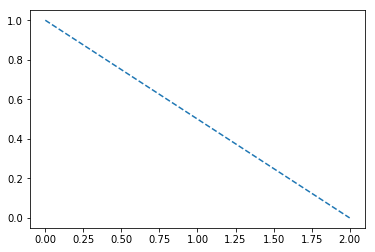

In [20]:


plt.plot([0,2],[1,0], '--')
output = plot_loglog(sorted(sites_edge_counts.values()))
plt.plot([0,2],[1,0], '--')
plt.draw()

In [ ]:
start_time = time.time()
pollutants_graph = bipartite.projected_graph(site_pollutant_graph_simple, 
                                        nodes=pollutants, multigraph=True)
print(time.time() - start_time)

# Start From Here! [20 Nov, 12:45 pm]
So we were able to make projection graphs for the sites and pollutants. We'll want to do some statistics on these! (So this should actually be moved to the Statistics section)

## Statistics [19 Nov, 11:30 pm]

### Defining some functions

In [ ]:
def plot_log_log(degrees, nbins = 20, plot_line = False):
    kmin = min(degrees)
    kmax = max(degrees)
    
    # Get logarithmically spaced bins between kmin and kmax
    #  adding to np.log10(kmax) because you want everything up to the 
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num = nbins)

    # Create a histogram of data with these bins
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    # Put x in the logarithmic midpoint of the bin edges
    log_bin_edges = np.log10(bin_edges)
    x = 10**((log_bin_edges[1:] + log_bin_edges[:-1])/2)
    
    # Start creating the figure
    fig = plt.figure(figsize=(6,6))
    
    # Use loglog function with x (midpoints) and density as the axes values
    #  We want this as a scatter plot
    plt.loglog(x, density, marker='o', linestyle='none')
    
    # Label the axes
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    
    # Plot the lines 
    plt.

#     # remove right and top boundaries because they're ugly
#     ax = plt.gca()
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')
    #fig.show()
    return x, density, fig

### The basics - Whole Bipartite Graph

In [ ]:
print("Total number of nodes:", site_pollutant_graph.number_of_nodes())
print("\tnumber of sites     :", len(sites))
print("\tnumber of pollutants:", len(pollutants))
print("Total number of edges:", site_pollutant_graph.number_of_edges())

It doesn't seem like you can actually get the degree distribution of the bipartite graph, so we'll have to do that on the subgraphs!

### The basics - Sites Graph 

In [ ]:
print("Total number of nodes:", sites_graph.number_of_nodes())
print("Total number of edges:", sites_graph.number_of_edges())
print("      of unique edges:", sites_graph.number_of_edges()) # need to change this!

In [ ]:
sites_degrees = [sites_graph.degree(site) for site in sites]

In [ ]:
print("Site Average degree (multigraph):", np.mean(sites_degrees))
print("Site Maximum degree (multigraph):", max(sites_degrees))
print("Site Minimum degree (multigraph):", min(sites_degrees))

In [ ]:
sites_simple_degrees = [sites_graph_simple.degree(site) for site in sites]

In [ ]:
sorted(sites_simple_degrees)

In [ ]:
print("Site Average degree (simple):", np.mean(sites_simple_degrees))
print("Site Maximum degree (simple):", max(sites_simple_degrees))
print("Site Minimum degree (simple):", min(sites_simple_degrees))

In [ ]:
output = plot_log_log(sorted(sites_simple_degrees), nbins=6)

### Graphing our Bipartite [copied from original] 

In [ ]:
pos = nx.spring_layout(site_pollutant_graph)

In [ ]:
plt.figure(figsize=(12,8))
labels = ["Sites", "Pollutants"]
colors = ["salmon", "lightblue"]
nx.draw_networkx_edges(site_pollutant_graph, pos=pos, width = 1, edge_color="darkgray")
for community, label, color in zip(bipartite.sets(site_pollutant_graph), labels, colors):
    nx.draw_networkx_nodes(site_pollutant_graph, pos=pos, 
                           nodelist=community,
                           node_color=color,
                           with_labels=False,
                           node_size=40,
                           label=label)

    #nx.draw_networkx_labels(site_pollutant_graph,pos=pos)
_=plt.axis("off")
_=plt.legend()
_=plt.title("Site-Pollutant Graph over All Time")

### Putting the plotting into a function [19 Nov, 9:30 pm]

In [ ]:
def plot_graph(G, title=""):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,8))
    labels = ["Sites", "Pollutants"]
    colors = ["salmon", "lightblue"]
    nx.draw_networkx_edges(G, pos=pos, width = 1, edge_color="darkgray")
    for community, label, color in zip(bipartite.sets(G), labels, colors):
        nx.draw_networkx_nodes(G, pos=pos, 
                               nodelist=community,
                               node_color=color,
                               with_labels=False,
                               node_size=40,
                               label=label)

        #nx.draw_networkx_labels(site_pollutant_graph,pos=pos)
    _=plt.axis("off")
    _=plt.legend()
    if title != "":
        _=plt.title(label=title)
    
    plt.show()
    return pos

### Let's try to make graphs for all the decades (after 1970)! [19 Nov, 1 pm]

In [ ]:
import time

In [ ]:
#https://stackoverflow.com/questions/26454649/python-round-up-to-the-nearest-ten
def round10(x):
    if x % 10 == 0:
        x += 1
    return ((x + 9) // 10) * 10

In [ ]:
start_time = time.time()
by_year = {year:[] for year in range(1970, 2030, 10)}

for u,v,e in site_pollutant_graph.edges(data = True):
    year = round10(int(e["Date"][:4]))
    if year < 1970:
        year = 1970
    by_year[year].append((u,v,e))
print(time.time()-start_time)

In [ ]:
graphs_by_year = { year:nx.MultiGraph(by_year[year]) for year in by_year }

#### Actual Graphs per Year [19 Nov, 9:30 pm]

In [ ]:
graph_pos = {}
for year in graphs_by_year:
    filename = "Graphs/Graph for data before {}.tsv".format(year)
    nx.write_edgelist(graphs_by_year[year], filename, delimiter="\t", 
                      data=["Date", "% Error", "Value", "Threshold", "Threshold Adhered To"])
    try:
        graph_pos[year] = plot_graph(graphs_by_year[year], 
                                     title="Site-Pollutant Graph Before {}".format(year))
    except:
        print("Year {} has {} components!".format( year,
                    nx.number_connected_components(graphs_by_year[year])))
        
        #https://stackoverflow.com/questions/8213522/when-to-use-cla-clf-or-close-for-clearing-a-plot-in-matplotlib
        plt.close()